# 📍📍 train + test

In [34]:
import pandas as pd
import numpy as np

train = pd.read_csv('/Users/pycode/project/데이터/train.csv')
# train.info()
# train.head()
# train.isna().sum()

In [35]:

test = pd.read_csv('/Users/pycode/project/데이터/test.csv')
# test.info()
# test.head()
test.isna().sum()

ID          0
매물확인방식      0
보증금         0
월세          0
전용면적      184
해당층        50
총층          2
방향          0
방수          2
욕실수         2
주차가능여부      0
총주차대수     175
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
dtype: int64

## 📍 데이터 타입 지정
* train, test 합치기 전에 데이터 타입 지정   
train -> 데이터타입 : 'train'    
test -> 데이터타입 : 'test' 
* concat으로 train + test

In [36]:
train['데이터타입'] = 'train'
test['데이터타입'] = 'test'
total_data = pd.concat([train.drop(columns='허위매물여부'), test])

# total_data.info()

## 📍 train + test 후 파생변수 생성
* 미기재
* 방치일수
* 집세

In [37]:
import datetime

# 미기재
total_data['미기재'] = total_data.isna().sum(axis=1)

# 방치일수
last = datetime.datetime.strptime(total_data['게재일'].max(), "%Y-%m-%d").date()
today = last + datetime.timedelta(days=1)

def get_delta_day(date):
    delta = today - datetime.datetime.strptime(date, "%Y-%m-%d").date()
    return delta.days

total_data['방치일수'] = total_data['게재일'].apply(lambda x: get_delta_day(x))

# 집세
total_data['집세'] = total_data['관리비'] * 10000 + total_data['월세']

# total_data.head()

# 📍📍 스케일링
-> MinMaxScaler 사용


In [38]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler객체 생성
scaler = MinMaxScaler()
# MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
cols_for_scale = ['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비', '미기재', '방치일수', '집세']
scaler.fit(total_data[cols_for_scale])
total_data[cols_for_scale] = scaler.transform(total_data[cols_for_scale])

# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
total_data_scaled = pd.DataFrame(data=total_data, columns=total_data.columns)
print('feature들의 최솟값')
print(total_data_scaled.min())
print('\nfeature들의 최댓값')
print(total_data_scaled.max())
total_data_scaled.head()

feature들의 최솟값
ID          TEST_000
매물확인방식          서류확인
보증금              0.0
월세               0.0
전용면적             0.0
해당층              0.0
총층               0.0
방향               남동향
방수               0.0
욕실수              0.0
주차가능여부            가능
총주차대수            0.0
관리비              0.0
중개사무소     A06Nz2Z1R1
제공플랫폼           A플랫폼
게재일       2023-04-28
데이터타입           test
미기재              0.0
방치일수             0.0
집세               0.0
dtype: object

feature들의 최댓값
ID        TRAIN_2451
매물확인방식          현장확인
보증금              1.0
월세               1.0
전용면적             1.0
해당층              1.0
총층               1.0
방향                서향
방수               1.0
욕실수              1.0
주차가능여부           불가능
총주차대수            1.0
관리비              1.0
중개사무소     z81HE4G4N5
제공플랫폼           N플랫폼
게재일       2025-03-03
데이터타입          train
미기재              1.0
방치일수             1.0
집세               1.0
dtype: object


,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,데이터타입,미기재,방치일수,집세
0,TRAIN_0000,현장확인,0.874587,0.626667,NaN,NaN,0.684211,서향,0.0,0.0,가능,0.066214,1.000000,t93Nt6I2I0,B플랫폼,2024-10-09,train,0.333333,0.214815,1.000000
1,TRAIN_0001,현장확인,0.364136,0.266667,NaN,0.10,0.105263,남동향,1.0,0.0,불가능,NaN,0.000000,q39iV5J4E6,D플랫폼,2024-12-26,train,0.333333,0.099259,0.139860
2,TRAIN_0002,전화확인,0.239824,0.506667,NaN,0.05,0.052632,동향,0.0,0.0,불가능,NaN,0.000000,b03oE4G3F6,A플랫폼,2024-11-28,train,0.333333,0.140741,0.265734
3,TRAIN_0003,현장확인,0.348735,0.040000,0.578996,0.10,0.368421,남동향,1.0,0.0,가능,0.020374,0.104167,G52Iz8V2B9,A플랫폼,2024-11-26,train,0.000000,0.143704,0.090909
4,TRAIN_0004,현장확인,0.750275,0.706667,NaN,0.10,0.052632,동향,1.0,0.0,불가능,NaN,0.000000,N45gM0M7R0,B플랫폼,2024-06-25,train,0.333333,0.371852,0.370629


# 📍📍 결측치 처리
-> Knn Imputer 사용

In [39]:
from sklearn.impute import KNNImputer

# KNN Imputer 적용
numeric_columns = total_data_scaled.select_dtypes(include=[np.number]).columns  # 숫자형 열만 선택
print(numeric_columns)
imputer = KNNImputer(n_neighbors=5)  # k=5 설정
data_knn_imputed = total_data_scaled.copy()
data_knn_imputed[numeric_columns] = imputer.fit(total_data_scaled[numeric_columns])
data_knn_imputed[numeric_columns] = imputer.transform(total_data_scaled[numeric_columns])

# 결측값 확인
# print(data_knn_imputed.isnull().sum())
data_knn_imputed.head()

Index(['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비', '미기재',
       '방치일수', '집세'],
      dtype='object')


,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,데이터타입,미기재,방치일수,집세
0,TRAIN_0000,현장확인,0.874587,0.626667,0.119433,0.32,0.684211,서향,0.0,0.0,가능,0.066214,1.000000,t93Nt6I2I0,B플랫폼,2024-10-09,train,0.333333,0.214815,1.000000
1,TRAIN_0001,현장확인,0.364136,0.266667,0.618355,0.10,0.105263,남동향,1.0,0.0,불가능,0.003056,0.000000,q39iV5J4E6,D플랫폼,2024-12-26,train,0.333333,0.099259,0.139860
2,TRAIN_0002,전화확인,0.239824,0.506667,0.194148,0.05,0.052632,동향,0.0,0.0,불가능,0.003735,0.000000,b03oE4G3F6,A플랫폼,2024-11-28,train,0.333333,0.140741,0.265734
3,TRAIN_0003,현장확인,0.348735,0.040000,0.578996,0.10,0.368421,남동향,1.0,0.0,가능,0.020374,0.104167,G52Iz8V2B9,A플랫폼,2024-11-26,train,0.000000,0.143704,0.090909
4,TRAIN_0004,현장확인,0.750275,0.706667,0.281614,0.10,0.052632,동향,1.0,0.0,불가능,0.001698,0.000000,N45gM0M7R0,B플랫폼,2024-06-25,train,0.333333,0.371852,0.370629


# 📍📍 train, test 데이터 분리

In [40]:
total_data_prepro = data_knn_imputed
train_data = total_data_prepro[total_data_prepro['데이터타입'] == 'train']
test_data = total_data_prepro[total_data_prepro['데이터타입'] == 'test']

train_data["허위매물여부"] = train.set_index("ID").loc[train_data["ID"], "허위매물여부"].values

train_data_mo = train_data.drop(columns=['ID', '게재일', '데이터타입'])
test_data_mo = test_data.drop(columns=['ID', '게재일', '데이터타입'])
print(train_data_mo.head())
print(test_data_mo.head())

  매물확인방식       보증금        월세      전용면적   해당층        총층   방향   방수  욕실수 주차가능여부  \
0   현장확인  0.874587  0.626667  0.119433  0.32  0.684211   서향  0.0  0.0     가능   
1   현장확인  0.364136  0.266667  0.618355  0.10  0.105263  남동향  1.0  0.0    불가능   
2   전화확인  0.239824  0.506667  0.194148  0.05  0.052632   동향  0.0  0.0    불가능   
3   현장확인  0.348735  0.040000  0.578996  0.10  0.368421  남동향  1.0  0.0     가능   
4   현장확인  0.750275  0.706667  0.281614  0.10  0.052632   동향  1.0  0.0    불가능   

      총주차대수       관리비       중개사무소 제공플랫폼       미기재      방치일수        집세  허위매물여부  
0  0.066214  1.000000  t93Nt6I2I0  B플랫폼  0.333333  0.214815  1.000000       0  
1  0.003056  0.000000  q39iV5J4E6  D플랫폼  0.333333  0.099259  0.139860       0  
2  0.003735  0.000000  b03oE4G3F6  A플랫폼  0.333333  0.140741  0.265734       0  
3  0.020374  0.104167  G52Iz8V2B9  A플랫폼  0.000000  0.143704  0.090909       0  
4  0.001698  0.000000  N45gM0M7R0  B플랫폼  0.333333  0.371852  0.370629       1  
  매물확인방식       보증금        월세      전용면적 

# 📍📍 오버샘플링
-> SMOTE 사용

In [41]:
import imblearn
print(imblearn.__version__)

0.13.0


In [42]:
train_data_mo.head()

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,미기재,방치일수,집세,허위매물여부
0,현장확인,0.874587,0.626667,0.119433,0.32,0.684211,서향,0.0,0.0,가능,0.066214,1.000000,t93Nt6I2I0,B플랫폼,0.333333,0.214815,1.000000,0
1,현장확인,0.364136,0.266667,0.618355,0.10,0.105263,남동향,1.0,0.0,불가능,0.003056,0.000000,q39iV5J4E6,D플랫폼,0.333333,0.099259,0.139860,0
2,전화확인,0.239824,0.506667,0.194148,0.05,0.052632,동향,0.0,0.0,불가능,0.003735,0.000000,b03oE4G3F6,A플랫폼,0.333333,0.140741,0.265734,0
3,현장확인,0.348735,0.040000,0.578996,0.10,0.368421,남동향,1.0,0.0,가능,0.020374,0.104167,G52Iz8V2B9,A플랫폼,0.000000,0.143704,0.090909,0
4,현장확인,0.750275,0.706667,0.281614,0.10,0.052632,동향,1.0,0.0,불가능,0.001698,0.000000,N45gM0M7R0,B플랫폼,0.333333,0.371852,0.370629,1


In [43]:
from imblearn.over_sampling import SMOTE

data_knn_imputed

total_data_smote = SMOTE(sampling_strategy='auto', random_state=0)
X_resampled, y_resampled = total_data_smote.fit_resample(X, y)

# 📍📍 인코딩
-> 레이블 인코딩 (Label encoding) 사용

In [44]:
# from sklearn.preprocessing import LabelEncoder

# def encode_features(dataDF):
#     features = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼']
#     for feature in features:
#         le = LabelEncoder()
#         le = le.fit(dataDF[feature])
#         dataDF[feature] = le.transform(dataDF[feature])
    
#     return dataDF

# total_data_encoded = encode_features(data_knn_imputed)
# total_data_encoded.head()

# 📍📍 XGBoost

In [45]:
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

from matplotlib import rc
rc('font', family='AppleGothic')

In [46]:
import xgboost as xgb

X_train = train_data_mo.iloc[:, :-1]
y_train = train_data_mo.iloc[:, -1]

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_tr.shape , X_val.shape)

X_test = test_data_mo.iloc[:, :]

(2206, 17) (246, 17)


In [47]:
from xgboost import XGBClassifier

# best param :  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=50, eval_metric='logloss', verbose=True)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_preds_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:매물확인방식, 방향, 주차가능여부, 중개사무소, 제공플랫폼

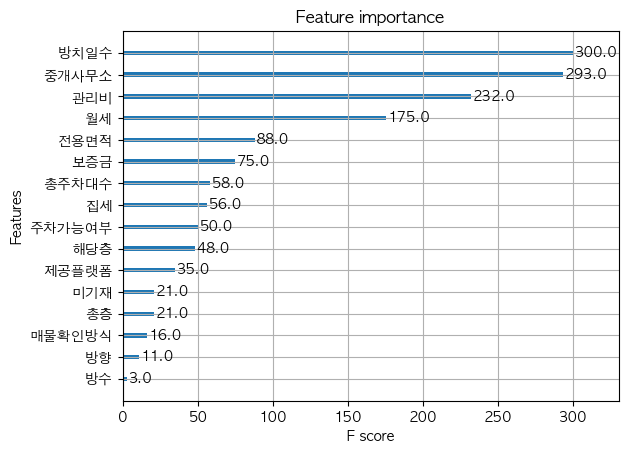

In [24]:
plot_importance(xgb_wrapper)
plt.show()

# 📍📍 LightGBM

In [25]:
import lightgbm
import xgboost
import sys

print(sys.version)
print(lightgbm.__version__)
print(xgboost.__version__)
# print()

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
3.3.5
1.6.0


In [27]:
from lightgbm import LGBMClassifier

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05, early_stopping_rounds=50)

In [ ]:
evals = [(X_tr, y_tr), (X_val, y_val)]

lgbm_wrapper.fit(X_tr, y_tr, eval_set=evals, eval_metric="logloss")
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[1]	training's binary_logloss: 0.333765	valid_1's binary_logloss: 0.325798
[2]	training's binary_logloss: 0.30678	valid_1's binary_logloss: 0.299004
[3]	training's binary_logloss: 0.285383	valid_1's binary_logloss: 0.278353
[4]	training's binary_logloss: 0.267539	valid_1's binary_logloss: 0.260795
[5]	training's binary_logloss: 0.25228	valid_1's binary_logloss: 0.246157
[6]	training's binary_logloss: 0.238642	valid_1's binary_logloss: 0.233615
[7]	training's binary_logloss: 0.226882	valid_1's binary_logloss: 0.222322
[8]	training's binary_logloss: 0.216122	valid_1's binary_logloss: 0.212124
[9]	training's binary_logloss: 0.206428	valid_1's binary_logloss: 0.203432
[10]	training's binary_logloss: 0.197423	valid_1's binary_logloss: 0.195251
[11]	training's binary_logloss: 0.189231	valid_1's binary_logloss: 0.187968
[12]	training's binary_logloss: 0.181558	